In [3]:
import sys
sys.path.append('../')
import corecomposition as cc

import numpy as np
import pyvo as vo
import pickle
import matplotlib.pyplot as plt

from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.table import Table, join

In [4]:
gold = Table.read('../data/processed/gold.csv')
silver = Table.read('../data/processed/silver.csv')
bronze = Table.read('../data/processed/bronze.csv')

In [5]:
photo = cc.photometry.fetch_photometry(bronze['wd_source_id'])
bronze = join(bronze, photo, keys_left='wd_source_id', keys_right='source_id')


In [6]:
source_ids = bronze['wd_source_id']
coords = [SkyCoord(frame="galactic", l=bronze['wd_l'][i]*u.deg, b=bronze['wd_b'][i]*u.deg, distance = bronze['distance'][i] * u.pc) for i in range(len(bronze))]
astrometric_params = bronze['wd_astrometric_params_solved']
photo = np.array([bronze['wd_phot_g_mean_mag'], bronze['wd_phot_bp_mean_mag'], bronze['wd_phot_rp_mean_mag']]).T
e_photo = np.array([bronze['wd_e_gmag'], bronze['wd_e_bpmag'], bronze['wd_e_rpmag']]).T
initial_params = np.array([bronze['CO_Hdef_teff'], bronze['CO_Hdef_radius']]).T

In [7]:
from dustmaps.edenhofer2023 import Edenhofer2023Query
bsq = Edenhofer2023Query()

Optimizing map for querying (this might take a couple of seconds)...


In [8]:
obj = cc.photometry.Photometry(source_ids, coords, astrometric_params, photo, e_photo, initial_params, bsq = bsq)

100%|██████████| 26/26 [00:00<00:00, 38.98it/s]


In [9]:
# 20.463974  
obj.photometry[0]

array([20.46395524, 20.26533889, 20.02453061, 20.49467261, 20.36938103,
       20.01028564, 19.78758849])

In [10]:
with open('../data/cleaned/radius_chains_CO_Hdef.pkl', 'rb') as f:
    co_hdef_chains = pickle.load(f)

with open('../data/cleaned/radius_chains_CO_Hrich.pkl', 'rb') as f:
    co_hrich_chains = pickle.load(f)

6178573689547383168


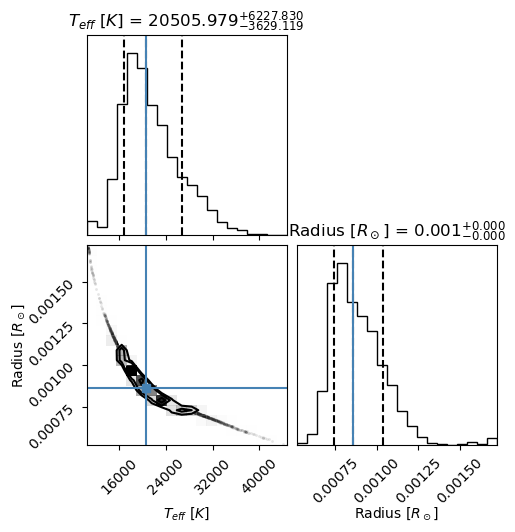

In [69]:
import corner

id = list(co_hdef_chains.keys())[21]

print(id)

labels = [r'$T_{eff}$ $[K]$', r'Radius $[R_\odot]$']
best_est = np.zeros((len(labels)))
unc = []

for i in range(len(labels)):
    mcmc = np.percentile(co_hdef_chains[id][:, i],[16,50,84])
    best_est[i] = mcmc[1]
    unc.append(np.diff(mcmc))
unc = np.array(unc)

emcee_plot = corner.corner(co_hdef_chains[id], labels=labels, truths = best_est, quantiles = [0.16, 0.5, 0.84], show_titles = True, 
                           title_fmt = '.3f', title_kwargs={"fontsize": 12})

plt.show()

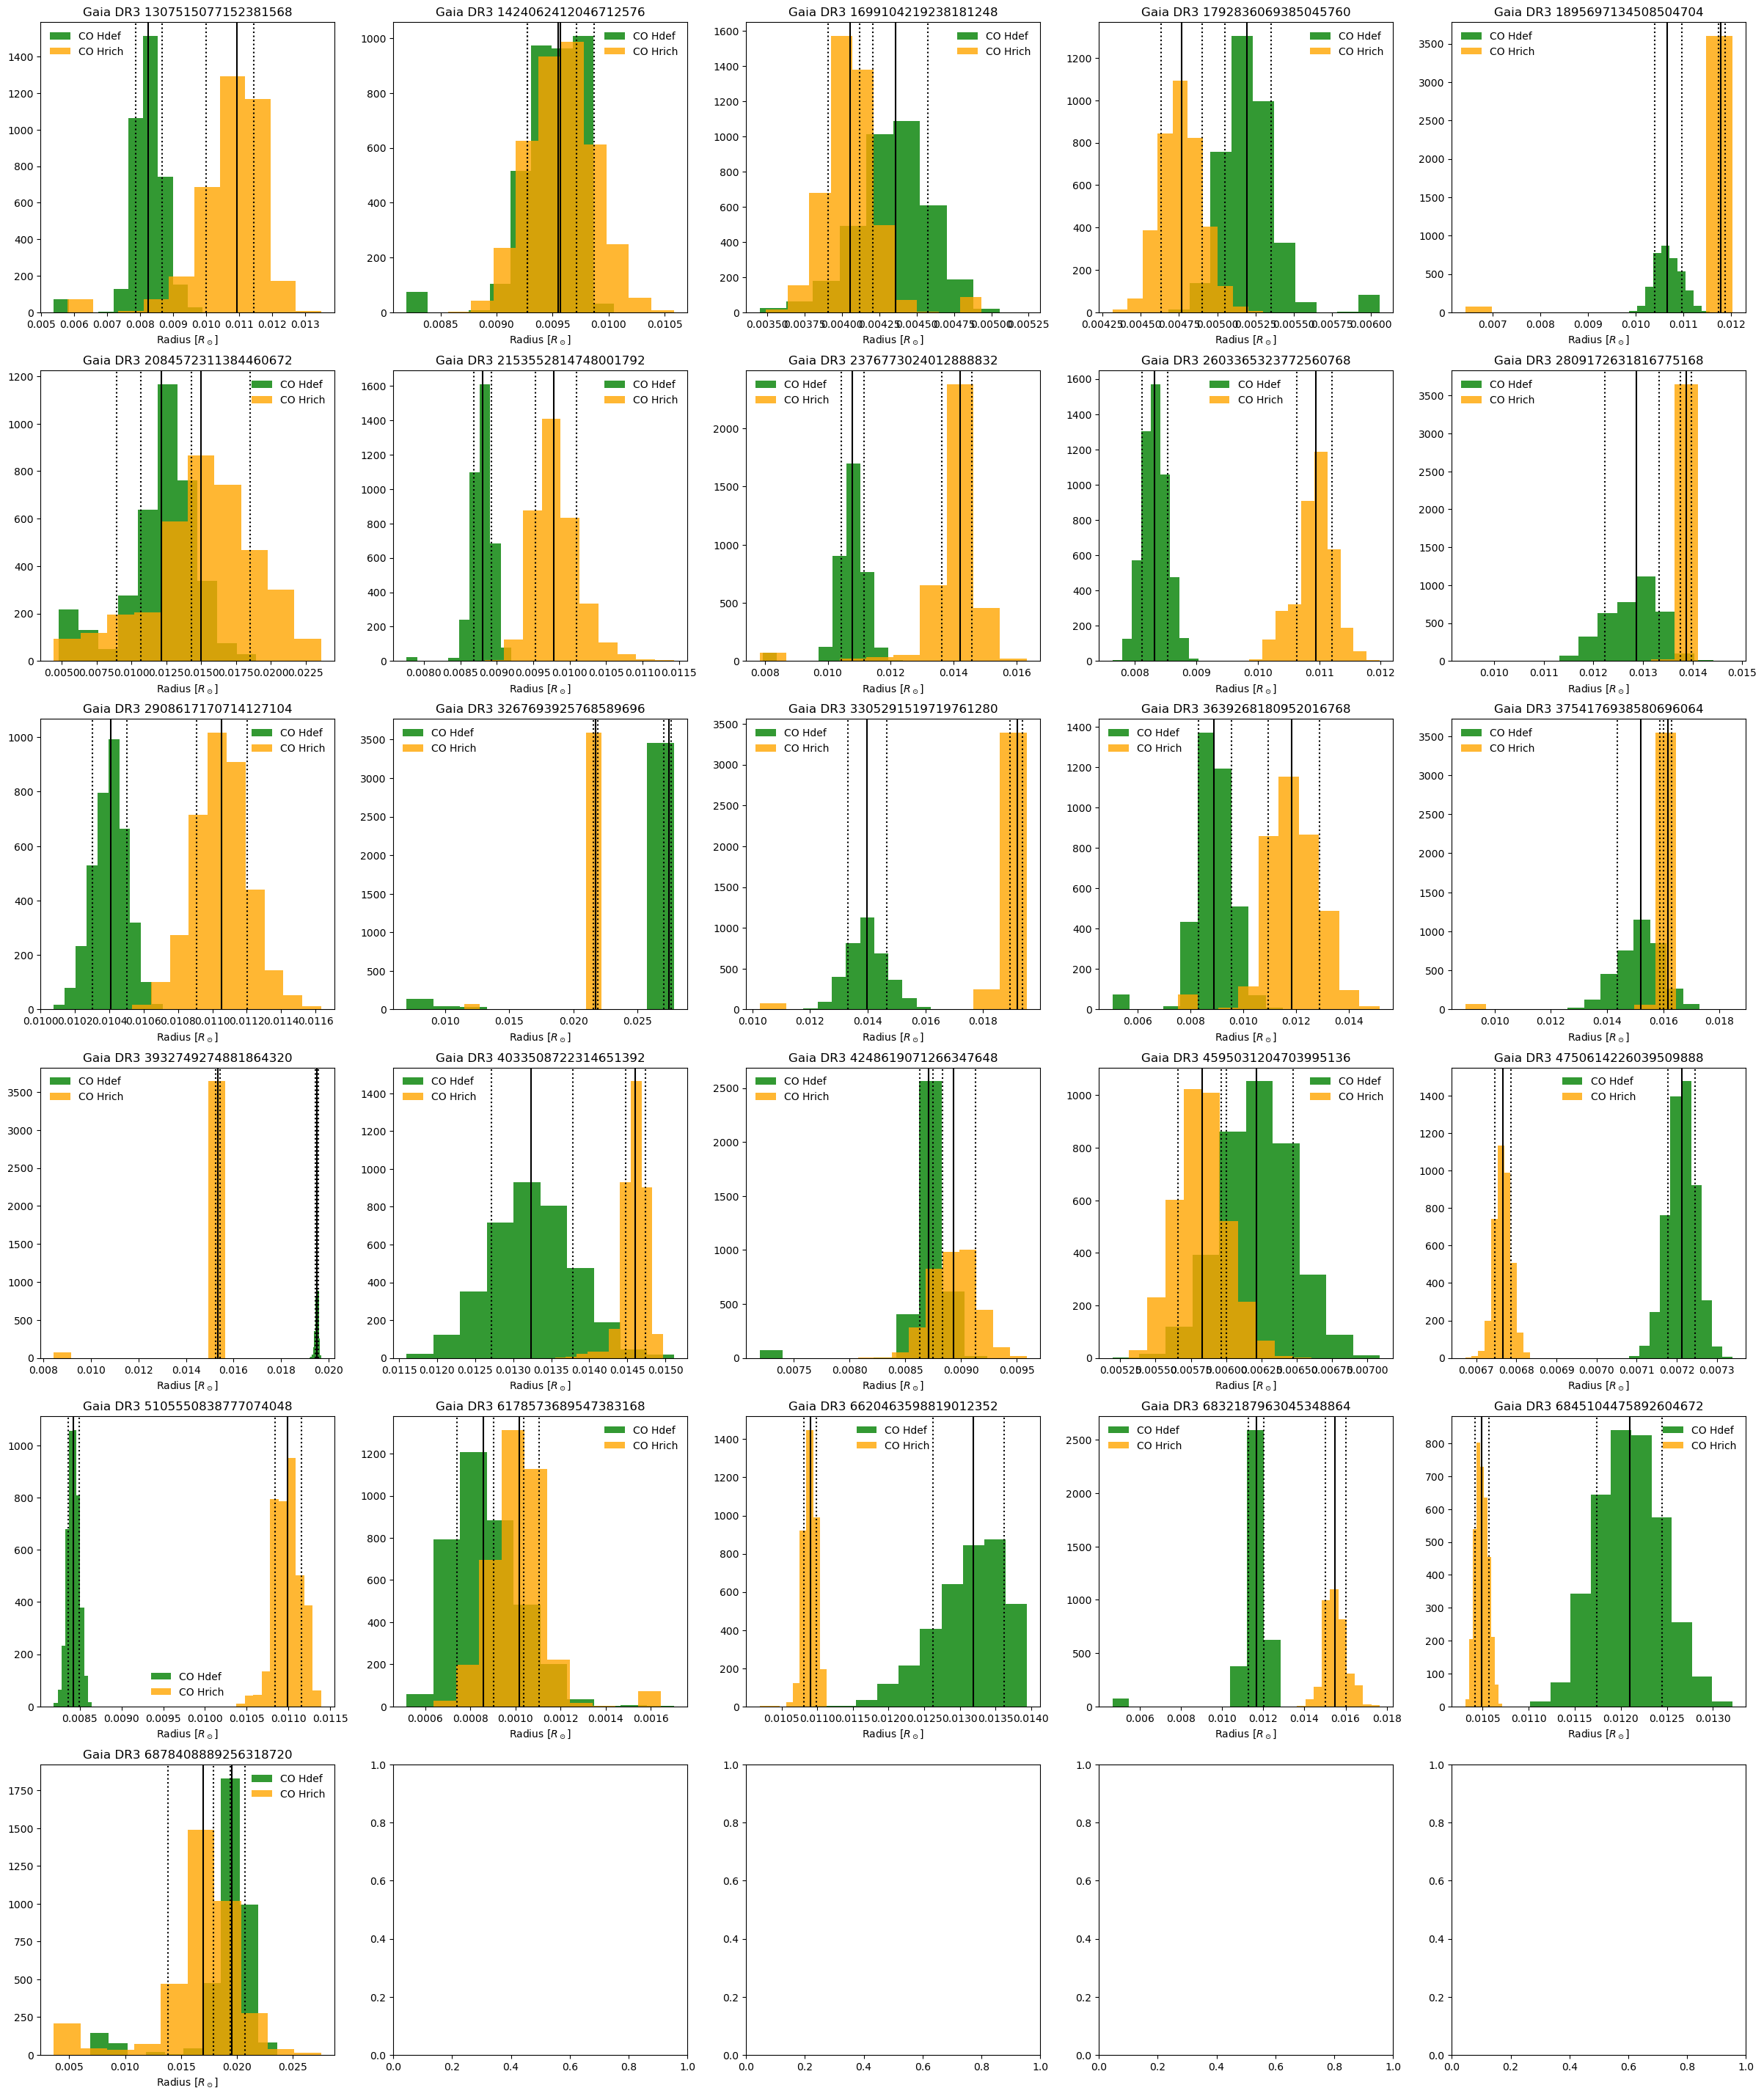

In [60]:
fig, ax = plt.subplots(nrows = 6, ncols = 5, figsize=(30, 36))
burn = 0.25

for i in range(ax.shape[0]):
    for j in range(ax.shape[1]):
        n = (i * ax.shape[1]) + j
        try:
            id = list(co_hdef_chains.keys())[n]
        except:
            break

        ax[i,j].set_title(f'Gaia DR3 {id}')
        co_hdef_burn = int(burn * co_hdef_chains[id].shape[0])
        co_hrich_burn = int(burn * co_hrich_chains[id].shape[0])

        ax[i,j].hist(co_hdef_chains[id][co_hdef_burn:,1], color = 'green', alpha = 0.8, label = 'CO Hdef')
        ax[i,j].hist(co_hrich_chains[id][co_hrich_burn:,1], color = 'orange', alpha = 0.8, label = 'CO Hrich')
        ax[i,j].legend(framealpha=0)
        ax[i,j].set_xlabel(r'Radius $[R_\odot]$')

        co_hdef_mcmc = np.percentile(co_hdef_chains[id][:,1],[16,50,84])
        ax[i,j].axvline(x = co_hdef_mcmc[1], c = 'k')
        ax[i,j].axvline(x = co_hdef_mcmc[0], c = 'k', ls = ':')
        ax[i,j].axvline(x = co_hdef_mcmc[2], c = 'k', ls = ':')

        co_hrich_mcmc = np.percentile(co_hrich_chains[id][:,1],[16,50,84])
        ax[i,j].axvline(x = co_hrich_mcmc[1], c = 'k')
        ax[i,j].axvline(x = co_hrich_mcmc[0], c = 'k', ls = ':')
        ax[i,j].axvline(x = co_hrich_mcmc[2], c = 'k', ls = ':')

In [62]:
np.percentile(co_hdef_chains[6178573689547383168][:,0], 50)

20505.97915410497

In [63]:
np.where(obj.source_ids == 6178573689547383168)

(array([21]),)

In [66]:
print(obj.bands[21])
print(obj.photometry[21])

['Gaia_G' 'Gaia_BP' 'Gaia_RP' 'PS1_g' 'PS1_r']
[20.36224937 20.30538177 20.23803139 20.20280075 20.24869919]


In [67]:
bronze[bronze['wd_source_id'] == 6178573689547383168]

wd_solution_id,ms_solution_id,wd_source_id,ms_source_id,wd_random_index,ms_random_index,wd_ref_epoch,ms_ref_epoch,wd_ra,ms_ra,wd_ra_error,ms_ra_error,wd_dec,ms_dec,wd_dec_error,ms_dec_error,wd_parallax,ms_parallax,wd_parallax_error,ms_parallax_error,wd_parallax_over_error,ms_parallax_over_error,wd_pm,ms_pm,wd_pmra,ms_pmra,wd_pmra_error,ms_pmra_error,wd_pmdec,ms_pmdec,wd_pmdec_error,ms_pmdec_error,wd_ra_dec_corr,ms_ra_dec_corr,wd_ra_parallax_corr,ms_ra_parallax_corr,wd_ra_pmra_corr,ms_ra_pmra_corr,wd_ra_pmdec_corr,ms_ra_pmdec_corr,wd_dec_parallax_corr,ms_dec_parallax_corr,wd_dec_pmra_corr,ms_dec_pmra_corr,wd_dec_pmdec_corr,ms_dec_pmdec_corr,wd_parallax_pmra_corr,ms_parallax_pmra_corr,wd_parallax_pmdec_corr,ms_parallax_pmdec_corr,wd_pmra_pmdec_corr,ms_pmra_pmdec_corr,wd_astrometric_n_obs_al,ms_astrometric_n_obs_al,wd_astrometric_n_obs_ac,ms_astrometric_n_obs_ac,wd_astrometric_n_good_obs_al,ms_astrometric_n_good_obs_al,wd_astrometric_n_bad_obs_al,ms_astrometric_n_bad_obs_al,wd_astrometric_gof_al,ms_astrometric_gof_al,wd_astrometric_chi2_al,ms_astrometric_chi2_al,wd_astrometric_excess_noise,ms_astrometric_excess_noise,wd_astrometric_excess_noise_sig,ms_astrometric_excess_noise_sig,wd_astrometric_params_solved,ms_astrometric_params_solved,wd_astrometric_primary_flag,ms_astrometric_primary_flag,wd_nu_eff_used_in_astrometry,ms_nu_eff_used_in_astrometry,wd_pseudocolour,ms_pseudocolour,wd_pseudocolour_error,ms_pseudocolour_error,wd_ra_pseudocolour_corr,ms_ra_pseudocolour_corr,wd_dec_pseudocolour_corr,ms_dec_pseudocolour_corr,wd_parallax_pseudocolour_corr,ms_parallax_pseudocolour_corr,wd_pmra_pseudocolour_corr,ms_pmra_pseudocolour_corr,wd_pmdec_pseudocolour_corr,ms_pmdec_pseudocolour_corr,wd_astrometric_matched_transits,ms_astrometric_matched_transits,wd_visibility_periods_used,ms_visibility_periods_used,wd_astrometric_sigma5d_max,ms_astrometric_sigma5d_max,wd_matched_transits,ms_matched_transits,wd_new_matched_transits,ms_new_matched_transits,wd_matched_transits_removed,ms_matched_transits_removed,wd_ipd_gof_harmonic_amplitude,ms_ipd_gof_harmonic_amplitude,wd_ipd_gof_harmonic_phase,ms_ipd_gof_harmonic_phase,wd_ipd_frac_multi_peak,ms_ipd_frac_multi_peak,wd_ipd_frac_odd_win,ms_ipd_frac_odd_win,wd_ruwe,ms_ruwe,wd_scan_direction_strength_k1,ms_scan_direction_strength_k1,wd_scan_direction_strength_k2,ms_scan_direction_strength_k2,wd_scan_direction_strength_k3,ms_scan_direction_strength_k3,wd_scan_direction_strength_k4,ms_scan_direction_strength_k4,wd_scan_direction_mean_k1,ms_scan_direction_mean_k1,wd_scan_direction_mean_k2,ms_scan_direction_mean_k2,wd_scan_direction_mean_k3,ms_scan_direction_mean_k3,wd_scan_direction_mean_k4,ms_scan_direction_mean_k4,wd_duplicated_source,ms_duplicated_source,wd_phot_g_n_obs,ms_phot_g_n_obs,wd_phot_g_mean_flux,ms_phot_g_mean_flux,wd_phot_g_mean_flux_error,ms_phot_g_mean_flux_error,wd_phot_g_mean_flux_over_error,ms_phot_g_mean_flux_over_error,wd_phot_g_mean_mag,ms_phot_g_mean_mag,wd_phot_bp_n_obs,ms_phot_bp_n_obs,wd_phot_bp_mean_flux,ms_phot_bp_mean_flux,wd_phot_bp_mean_flux_error,ms_phot_bp_mean_flux_error,wd_phot_bp_mean_flux_over_error,ms_phot_bp_mean_flux_over_error,wd_phot_bp_mean_mag,ms_phot_bp_mean_mag,wd_phot_rp_n_obs,ms_phot_rp_n_obs,wd_phot_rp_mean_flux,ms_phot_rp_mean_flux,wd_phot_rp_mean_flux_error,ms_phot_rp_mean_flux_error,wd_phot_rp_mean_flux_over_error,ms_phot_rp_mean_flux_over_error,wd_phot_rp_mean_mag,ms_phot_rp_mean_mag,wd_phot_bp_n_contaminated_transits,ms_phot_bp_n_contaminated_transits,wd_phot_bp_n_blended_transits,ms_phot_bp_n_blended_transits,wd_phot_rp_n_contaminated_transits,ms_phot_rp_n_contaminated_transits,wd_phot_rp_n_blended_transits,ms_phot_rp_n_blended_transits,wd_phot_proc_mode,ms_phot_proc_mode,wd_phot_bp_rp_excess_factor,ms_phot_bp_rp_excess_factor,wd_bp_rp,ms_bp_rp,wd_bp_g,ms_bp_g,wd_g_rp,ms_g_rp,wd_dr2_radial_velocity,ms_dr2_radial_velocity,wd_dr2_radial_velocity_error,ms_dr2_radial_velocity_error,wd_dr2_rv_nb_transits,ms_dr2_rv_nb_transits,wd_dr2_rv_template_teff,ms_dr2